In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path



# Preprocessing

## Parameters

In [3]:
# parameters

_round_num = 2
# _symbol = "COCONUTS"
_symbol = "PINA_COLADAS"
# _day_ind = -2
_day_range = [-1, 0, 1]
_book_range = list(range(1, 3+1))
_max_time = 1000000
_time_step = 100

In [4]:
def get_file_trades(day):
    fname = f"../data/round{_round_num}/trades_round_{_round_num}_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

## read data

In [304]:
# get data for each day
trades = []
prices = []

for day in _day_range:
    # get data from files
    trade_df = get_file_trades(day)
    price_df = get_file_prices(day)
    
    trade_df["day"] = day
    
    trades += [trade_df]
    prices += [price_df]

# concat all data
trade_df = pd.concat(trades)
price_df = pd.concat(prices)

# reset indexes
trade_df = trade_df.reset_index(drop=True)
price_df = price_df.reset_index(drop=True)


# print columns that we believe to be irrelevant
# currency - SEASHELLS only
# buyer - nan only
# seller - nan only
display(trade_df["currency"].value_counts())
display(trade_df["buyer"].value_counts())
display(trade_df["seller"].value_counts())

# drop irrelevant columns
trade_df = trade_df.drop(["currency", "buyer", "seller"], axis=1)

# rename columns
price_df = price_df.rename({"product": "symbol"}, axis=1)
price_df = price_df.rename({"timestamp": "time"}, axis=1)

trade_df = trade_df.rename({"timestamp": "time"}, axis=1)

# filter for specific symbol
trade_df = trade_df[trade_df["symbol"] == _symbol]
price_df = price_df[price_df["symbol"] == _symbol]

# calculate new time (for multiday)
trade_df["time"] = trade_df["time"] + (trade_df["day"] - min(_day_range)) * _max_time
price_df["time"] = price_df["time"] + (price_df["day"] - min(_day_range)) * _max_time

# rename "bid" to "buy"
# rename "ask" to "sell"
price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)


fname ../data/round2/trades_round_2_day_-1_nn.csv
fname ../data/round2/prices_round_2_day_-1.csv
fname ../data/round2/trades_round_2_day_0_nn.csv
fname ../data/round2/prices_round_2_day_0.csv
fname ../data/round2/trades_round_2_day_1_nn.csv
fname ../data/round2/prices_round_2_day_1.csv


SEASHELLS    17815
Name: currency, dtype: int64

Series([], Name: buyer, dtype: int64)

Series([], Name: seller, dtype: int64)

In [305]:
# clean unreasonable data

if _symbol == "BANANAS":
    display(trade_df[trade_df["price"] < 4500])
    display(trade_df[trade_df["price"] > 5500])

    trade_df = trade_df[trade_df["price"] >= 4500]
    trade_df = trade_df[trade_df["price"] <= 5500]



# Large Quotes

## calculate large quote data

In [306]:
def get_book_large_size(side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df

In [307]:
# get big buy/sell quotes
buy_df = get_book_large_size("buy")
sell_df = get_book_large_size("sell")

# create big quote_df
quote_df = pd.merge(buy_df, sell_df, on="time")
quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

# edge is calculated from perspective of seller (it is the price )
trade_df = trade_df.merge(quote_df[["time", "mid_price"]], on="time")
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid_price"]

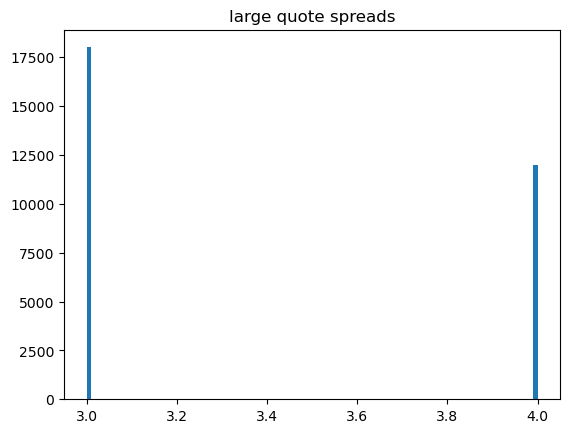

,index,spread
0,3.0,18012
1,4.0,11988


In [308]:
plt.hist(quote_df["spread"], bins=100)
plt.title("large quote spreads")
plt.show()

display(quote_df["spread"].value_counts().reset_index())

## whale quote: order over time

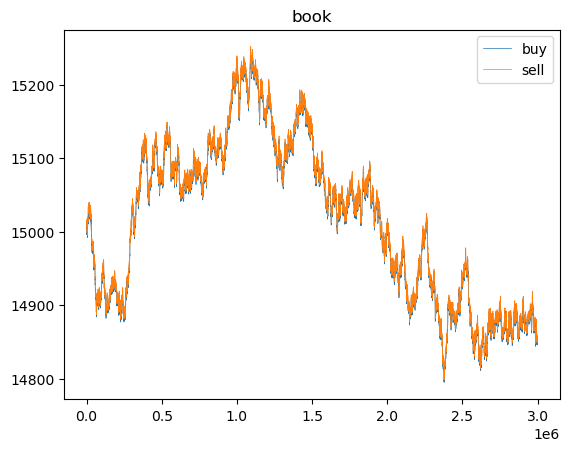

In [309]:
# lb, ub = 2e6, 2e6+1e5
# quote_df = quote_df[lb <= quote_df["time"]]
# quote_df = quote_df[quote_df["time"] <= ub]

plt.plot(quote_df["time"], quote_df["buy_price"], linewidth=0.5, label="buy")
plt.plot(quote_df["time"], quote_df["sell_price"], linewidth=0.5, label="sell")
plt.title("book")
plt.legend()

In [310]:
quote_df

,buy_price,buy_size,time,sell_price,sell_size,mid_price,spread
0,14998.0,53.0,0,15002.0,53.0,15000.0,4.0
1,14998.0,64.0,100,15002.0,64.0,15000.0,4.0
2,14998.0,106.0,200,15001.0,106.0,14999.5,3.0
3,14998.0,67.0,300,15002.0,67.0,15000.0,4.0
4,14997.0,69.0,400,15001.0,69.0,14999.0,4.0
...,...,...,...,...,...,...,...
29995,14849.0,103.0,2999500,14853.0,69.0,14851.0,4.0
29996,14852.0,66.0,2999600,14856.0,66.0,14854.0,4.0
29997,14849.0,105.0,2999700,14852.0,105.0,14850.5,3.0
29998,14849.0,101.0,2999800,14852.0,101.0,14850.5,3.0


## whale quote: sizing histogram

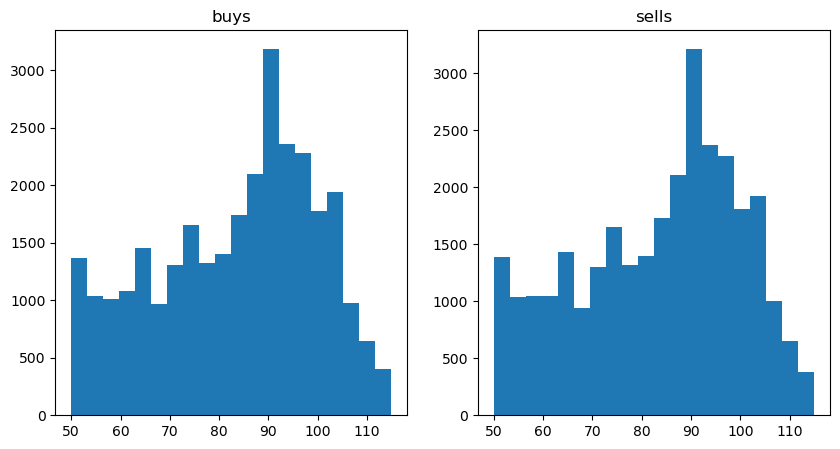

,index,buy_size
0,95.0,829
1,92.0,818
2,91.0,814
3,96.0,788
4,89.0,780
...,...,...
61,111.0,185
62,112.0,158
63,113.0,121
64,114.0,71


,index,sell_size
0,91.0,839
1,95.0,829
2,92.0,819
3,93.0,800
4,90.0,795
...,...,...
61,111.0,187
62,112.0,148
63,113.0,113
64,114.0,67


In [311]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(quote_df["buy_size"], bins=20)
plt.title("buys")

plt.subplot(122)
plt.hist(quote_df["sell_size"], bins=20)
plt.title("sells")

plt.show()


display(quote_df["buy_size"].value_counts().reset_index())
display(quote_df["sell_size"].value_counts().reset_index())

## whale quote: mid_price change stats

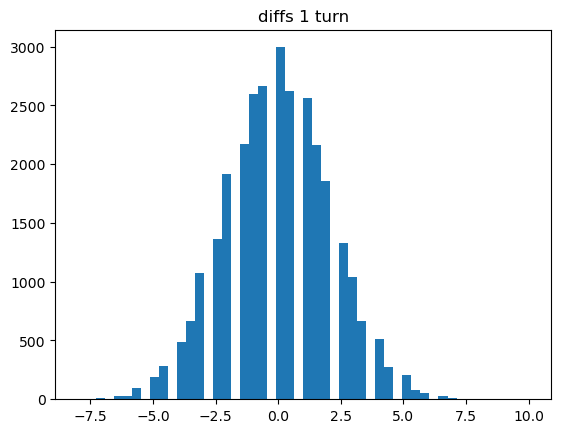

,count,mean,std,min,25%,50%,75%,max
mid_price,29999.0,-0.004967,2.111032,-8.0,-1.5,0.0,1.5,10.0


std size 365.63535988435734
total change -149.0
z-score -0.4075098208420693


In [312]:
# diffs
diffs = quote_df["mid_price"] - quote_df["mid_price"].shift(1)
diffs = diffs.dropna()

_ = plt.hist(diffs, bins=50)
plt.title("diffs 1 turn")
plt.show()


diff_desc = pd.DataFrame(diffs).describe().T
display(diff_desc)

stdev = np.sqrt(len(diffs))* diff_desc["std"].iloc[0]
print("std size", stdev)
print("total change", diffs.sum())
print("z-score", diffs.sum() / stdev)

# Postbook

## postbook helper methods

In [313]:
def get_postbook_bounds(time, interval):
    
    # get nearest 100k
    
    lb = (time // interval) * interval
    ub = lb + interval
        
    # filter data to only use interval
    ts = trade_df[(lb < trade_df["time"]) & (trade_df["time"] < ub)]
    ps = price_df[(lb < price_df["time"]) & (price_df["time"] < ub)]
    

    # calc min/max prices
    min_prices = []
    max_prices = []

    for i in _book_range:
        prices = ps[f"buy_price_{i}"]
        min_prices += [prices.min()]
        max_prices += [prices.max()]

    for i in _book_range:
        prices = ps[f"sell_price_{i}"]
        min_prices += [prices.min()]
        max_prices += [prices.max()]

    prices = ts["price"]
    min_prices += [prices.min()]
    max_prices += [prices.max()]


    xmin = min(min_prices)
    xmax = max(max_prices)
    
    
    
    # calc min/max sizes
    
    max_sizes = []
    
    # include 
    for i in _book_range:
        sizes = ps[f"buy_volume_{i}"]
        max_sizes += [sizes.max()]
        
    for i in _book_range:
        sizes = ps[f"sell_volume_{i}"]
        max_sizes += [sizes.max()]
    
    # include trade sizes
    max_sizes += [trade_df["quantity"].max()]
    
    ymin = 0
    ymax = max(max_sizes)
    
    return xmin, xmax, ymin, ymax

In [314]:
def get_book(sym, time):
    cur_prices = price_df[price_df["time"] == time].iloc[0]
    
    buys = []

    for i in _book_range:
        price, size = cur_prices[f"buy_price_{i}"], cur_prices[f"buy_volume_{i}"]
        if np.isnan(price):
            continue
        buys += [{"price": price, "quantity": size}]

    sells = []

    for i in _book_range:
        price, size = cur_prices[f"sell_price_{i}"], cur_prices[f"sell_volume_{i}"]
        if np.isnan(price):
            continue
        sells += [{"price": price, "quantity": size}]
        
    buys = pd.DataFrame(buys, columns=["price", "quantity"])
    sells = pd.DataFrame(sells, columns=["price", "quantity"])
    
    empty = pd.DataFrame([], columns=["price", "quantity"])

    return buys, sells, empty, empty


def get_trades(sym, time):
    
#     market_ts = trade_df[(trade_df["symbol"] == sym) & (trade_df["time"] == time)]
    market_ts = trade_df[trade_df["time"] == time]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
#     my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, pd.DataFrame([], columns=market_ts.columns)
    

def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    market_ts, my_ts = get_trades(sym, time + _time_step)

    
    # make bars have correct sign
#     sells["quantity"] *= -1
#     my_buys["quantity"] *= -1
#     my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    ref_ema = quote_df[quote_df["time"] == time]["mid_price"].iloc[0]
    plt.axvline(x=ref_ema, color="black", linestyle='dotted')
    
#     ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time}")
#     plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span}")
    plt.show()
    
    
    ### print raw info
#     print("ref_ema", ref_ema)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
def show_book_simple(
        sym,
        time=0,
        bound_interval=10000,
        # ymin=None,
        # ymax=None,
        ):
    
    xmin, xmax, ymin, ymax = get_postbook_bounds(time, bound_interval)
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=-10,
        ymax=ymax,
    )

## Postbook reconstruction

In [315]:

interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS", "PINA_COLADAS", "COCONUTS"],
    time=(0, len(_day_range) * _max_time, _time_step),
    bound_interval=10000,
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS', 'PINA_COLADAS', 'COCONUTS'), v…

<function __main__.show_book_simple(sym, time=0, bound_interval=10000)>

In [ ]:
# filter between our times
# trade_df = trade_df[(2e6 <= trade_df["time"]) & (trade_df["time"] < 2e6 + 1e5)]
# price_df = price_df[(2e6 <= price_df["time"]) & (price_df["time"] < 2e6 + 1e5)]


## Best Taker Analysis

In [316]:
# get all buy_order_df
buy_data = [price_df[[f"buy_price_{i}", f"buy_volume_{i}", "time"]] for i in _book_range]
buy_data = [df.set_axis(labels=["price", "quantity", "time"], axis=1) for df in buy_data]
buy_df = pd.concat(buy_data).dropna()
buy_df = buy_df.sort_values(by="time").reset_index(drop=True)

# get all sell_order_df
sell_data = [price_df[[f"sell_price_{i}", f"sell_volume_{i}", "time"]] for i in _book_range]
sell_data = [df.set_axis(labels=["price", "quantity", "time"], axis=1) for df in sell_data]
sell_df = pd.concat(sell_data).dropna()
sell_df = sell_df.sort_values(by="time").reset_index(drop=True)

# negate quantity for sells
sell_df["quantity"] *= -1

In [317]:
# combine buy_df/sell_df into order_df
order_df = pd.concat([buy_df, sell_df]) \
                .sort_values(by=["time", "price"], ascending=True) \
                .reset_index(drop=True)

# merge mid_price (of large quotes) into order_df
order_df = order_df.merge(quote_df[["time", "mid_price"]], on="time")

# calculate edge if this order goes through
order_df["edge"] = np.sign(order_df["quantity"]) * (order_df["mid_price"] - order_df["price"])


In [327]:
# find orders with negative edge for maker (taker wins)
taker_df = order_df[order_df["edge"] <= 0].copy()

taker_df["edge"] = -1 * taker_df["edge"]

taker_df["abs_quantity"] = taker_df["quantity"].abs()
taker_df["pnl"] = taker_df["edge"] * taker_df["abs_quantity"]

# is buy from our perspective
taker_df["is_buy"] = taker_df["quantity"] > 0


In [328]:
# calculate total potential taker profit
print("take edge total", taker_df["pnl"].sum())

take edge total 18771.0


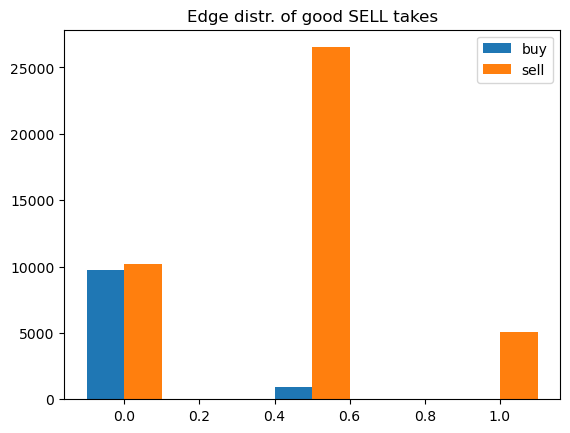

,buy_quantity,sell_quantity
edge,,
-0.0,9744.0,10204.0
0.5,932.0,26516.0
1.0,NaN,5047.0


In [348]:
# show distribution of edge (by volume)

buy_taker_df = taker_df[taker_df["is_buy"]]
sell_taker_df = taker_df[~taker_df["is_buy"]]

buy_take_stats = buy_taker_df.groupby("edge")[["abs_quantity"]].sum()
sell_take_stats = sell_taker_df.groupby("edge")[["abs_quantity"]].sum()

bar_width = 0.1

plt.bar(abs(buy_take_stats.index) - bar_width / 2, buy_take_stats["abs_quantity"], width=bar_width, label="buy")
# plt.title("Edge distr. of good BUY takes")
# plt.legend()
# plt.show()

plt.bar(abs(sell_take_stats.index) + bar_width / 2, sell_take_stats["abs_quantity"], width=bar_width, label="sell")
plt.title("Edge distr. of good SELL takes")
plt.legend()
plt.show()


display(pd.concat([buy_take_stats, sell_take_stats], axis=1).set_axis(["buy_quantity", "sell_quantity"], axis=1))

## Best maker analysis

In [321]:
# print total maker volume over sample time
sample_size = trade_df[(trade_df["time"] > 2e6) & (trade_df["time"] < 2e6 + 1e5)][["quantity"]].abs().sum()
print("Sample - total edge volume", sample_size.item())

Sample - total edge volume 197


In [324]:
# show total maker profit
maker_df = trade_df.copy()

maker_df["edge"] = maker_df["sell_edge"]
maker_df["quantity"] = maker_df["quantity"].abs() # is already pos, does nothing

maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

edge,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0
quantity,101,1455,5732,297,72,329,155,358,73


<BarContainer object of 9 artists>

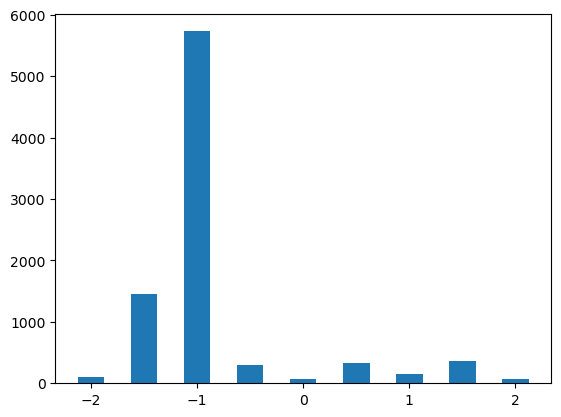

In [325]:
maker_stats = maker_df.groupby("edge")[["quantity"]].sum()
display(maker_stats.T)

plt.bar(maker_stats.index, maker_stats["quantity"], width=0.25)

## Maker/taker stats summary

In [26]:
_factor = 1 / 30

print(f"Symbol: {_symbol}")

print("Total Maker Edge", maker_df["pnl"].sum())
print("Total Potential Taker Edge", taker_df["pnl"].sum())

print("Maker edge (scaled)", maker_df["pnl"].sum() * _factor)
print("Taker edge (scaled)", taker_df["pnl"].sum() * _factor)


Symbol: PINA_COLADAS
Total Maker Edge 9267.5
Total Potential Taker Edge 18771.0
Maker edge (scaled) 308.9166666666667
Taker edge (scaled) 625.7


In [27]:
num_turns = len(_day_range) * _max_time / _time_step
print("num turns", num_turns)
print("take ratio", len(taker_df) / num_turns)
print("make ratio", len(maker_df) / num_turns)



num turns 30000.0
take ratio 0.0651
make ratio 0.028466666666666668


In [28]:
quote_df

,buy_price,buy_size,time,sell_price,sell_size,mid_price,spread
0,14998.0,53.0,0,15002.0,53.0,15000.0,4.0
1,14998.0,64.0,100,15002.0,64.0,15000.0,4.0
2,14998.0,106.0,200,15001.0,106.0,14999.5,3.0
3,14998.0,67.0,300,15002.0,67.0,15000.0,4.0
4,14997.0,69.0,400,15001.0,69.0,14999.0,4.0
...,...,...,...,...,...,...,...
29995,14849.0,103.0,2999500,14853.0,69.0,14851.0,4.0
29996,14852.0,66.0,2999600,14856.0,66.0,14854.0,4.0
29997,14849.0,105.0,2999700,14852.0,105.0,14850.5,3.0
29998,14849.0,101.0,2999800,14852.0,101.0,14850.5,3.0


# Linreg

## linreg on large quote mid price

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
_turn_diffs = [-1, -10]
_pred_diff = 10

data = []

# get input data
for diff in _turn_diffs:
    data += [quote_df["mid_price"] - quote_df["mid_price"].shift(-1 * diff)]

# get output data
data += [quote_df["mid_price"].shift(-1 * _pred_diff) - quote_df["mid_price"]]

# form X, y - clean data
X = pd.concat(data, axis=1)
X = X.dropna()
X.columns = [f"d_{diff}" for diff in [*_turn_diffs, _pred_diff]]

y = X[[f"d_{_pred_diff}"]]
X = X.drop(f"d_{_pred_diff}", axis=1)

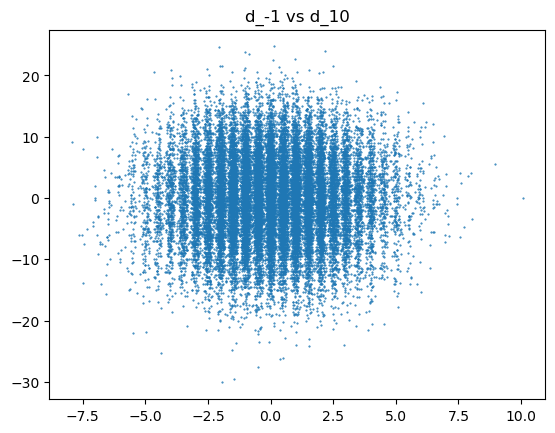

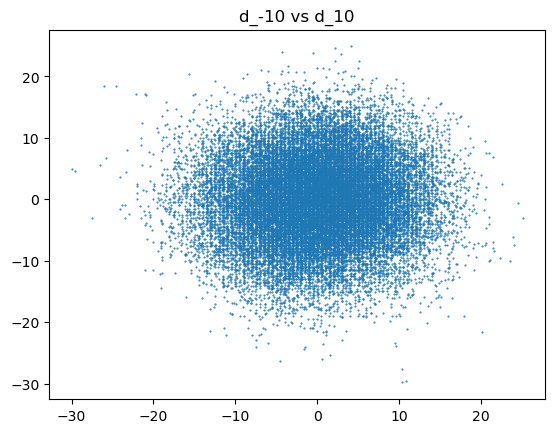

In [31]:
for col in X.columns:
    Xp = X[col] + np.random.normal(scale=0.1, size=X[col].shape)
    yp = y + np.random.normal(scale=0.1, size=y.shape)
    plt.scatter(Xp, yp, s=0.25)
    plt.title(col + " vs " + y.columns[0])
    plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-30. , -28.9, -27.8, -26.7, -25.6, -24.5, -23.4, -22.3, -21.2,
        -20.1, -19. , -17.9, -16.8, -15.7, -14.6, -13.5, -12.4, -11.3,
        -10.2,  -9.1,  -8. ,  -6.9,  -5.8,  -4.7,  -3.6,  -2.5,  -1.4,
         -0.3,   0.8,   1.9,   3. ,   4.1,   5.2,   6.3,   7.4,   8.5,
          9.6,  10.7,  11.8,  12.9,  14. ,  15.1,  16.2,  17.3,  18.4,
         19.5,  20.6,  21.7,  22.8,  23.9,  25. ]),
 array([-30. , -28.9, -27.8, -26.7, -25.6, -24.5, -23.4, -22.3, -21.2,
        -20.1, -19. , -17.9, -16.8, -15.7, -14.6, -13.5, -12.4, -11.3,
        -10.2,  -9.1,  -8. ,  -6.9,  -5.8,  -4.7,  -3.6,  -2.5,  -1.4,
         -0.3,   0.8,   1.9,   3. ,   4.1,   5.2,   6.3,   7.4,   8.5,
          9.6,  10.7,  11.8,  12.9,  14. ,  15.1,  16.2,  17

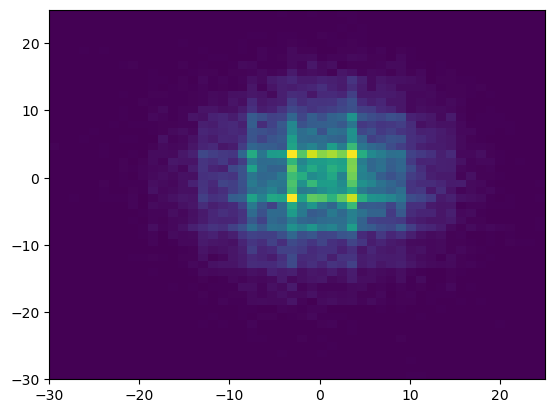

In [32]:
plt.hist2d(X[col], y[y.columns[0]], bins=50)

,count,mean,std,min,25%,50%,75%,max
d_10,29980.0,-0.052835,6.696149,-30.0,-4.5,0.0,4.5,25.0


,count,mean,std,min,25%,50%,75%,max
d_10,29980.0,5.336724,4.044704,0.0,2.0,4.5,7.5,30.0


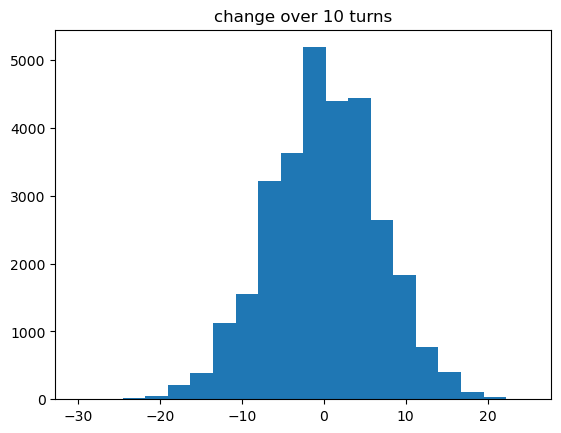

In [33]:
plt.title(f"change over {_pred_diff} turns")
plt.hist(y, bins=20)

display(y.describe().T)
display(abs(y).describe().T)


In [34]:
reg = LinearRegression().fit(X, y)
display(reg.coef_)
display(reg.intercept_)

array([[-0.02470725,  0.03284445]])

array([-0.05133866])

In [35]:
print("coeffs", sum(reg.coef_))
print("intercept", sum(reg.intercept_))
print("score", reg.score(X, y))

coeffs [-0.02470725  0.03284445]
intercept -0.051338661109582476
score 0.0009767106634543943


In [36]:
error = reg.predict(X) - y
error["abs"] = abs(error[f"d_{_pred_diff}"])

error.describe().T

,count,mean,std,min,25%,50%,75%,max
d_10,29980.0,-3.792089e-18,6.692878,-24.919961,-4.493787,-0.092394,4.481358,30.342943
abs,29980.0,5.337835e+00,4.037472,0.001849,2.108945,4.485798,7.702476,30.342943


In [37]:
pd.DataFrame(reg.predict(X)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,29980.0,-0.052835,0.209271,-0.974904,-0.191001,-0.051339,0.088324,0.815119


# Pairs analysis


In [38]:
del _turn_diffs
del _pred_diff
del quote_df

## load data

In [39]:
pina_quote_df_path = 'PINA_COLADAS_quote_df.csv'
coco_quote_df_path = 'COCONUTS_quote_df.csv'
if not os.path.isfile(pina_quote_df_path) or not os.path.isfile(coco_quote_df_path):
    print("files dont exists")
    print(os.path.isfile(pc_quote_df_path))
    print(os.path.isfile(coco_quote_df_path))

# read orig quote_df's from files
pina_quote_df = pd.read_csv(pina_quote_df_path, index_col=0)
coco_quote_df = pd.read_csv(coco_quote_df_path, index_col=0)


In [40]:
# calculate pair_quote_df
pair_quote_df = pina_quote_df[["time"]].copy()
pair_quote_df["mid_diff"] = pina_quote_df["mid_price"] - 1 * coco_quote_df["mid_price"]
pair_quote_df["mid_ratio"] = pina_quote_df["mid_price"] / coco_quote_df["mid_price"]


## func - get_rtns, scatter_noise

In [201]:
def get_rtns(quote_df, turn_offsets):
    
    data = []
    
    for diff in turn_offsets:
        shifted = quote_df["mid_price"].shift(-1 * diff)
        
        if diff < 0:
            data += [quote_df["mid_price"] - shifted]
        else:
            data += [shifted - quote_df["mid_price"]]
        
    rtn_df = pd.concat(data, axis=1)
    rtn_df.columns = [f"d_{diff}" for diff in turn_offsets]
    
    return rtn_df.dropna()
 
    

In [202]:
def scatter_noise(x, y, xnoise=0.1, ynoise=0.1, s=0.1, label=None):
    xp = x + np.random.normal(scale=xnoise, size=len(x))
    yp = y + np.random.normal(scale=ynoise, size=len(y))
    
    plt.scatter(
        xp, yp, 
        s=s, 
        label=label,
    )

## Calc returns

In [203]:
turn_offsets = [-500, -100, -50, -30, -10, -1, 1, 10, 30, 50, 100, 500]

# calc rtns
pina_rtn_df = get_rtns(pina_quote_df, turn_offsets=turn_offsets)
coco_rtn_df = get_rtns(coco_quote_df, turn_offsets=turn_offsets)

pair_rtn_df = pina_rtn_df - coco_rtn_df
pair_rtn_df = pair_rtn_df.add_prefix("rel_")

In [205]:
# validation

index = 500
print("cur time")
display(pina_quote_df.loc[[index, index + 500]])
display(coco_quote_df.loc[[index, index + 500]])

print("cur rtns")
display(pina_rtn_df.loc[[index, index + 500]])
display(coco_rtn_df.loc[[index, index + 500]])
display(pair_rtn_df.loc[[index, index + 500]])


cur time


,buy_price,buy_size,time,sell_price,sell_size,mid_price,spread
500,14965.0,91.0,50000,14968.0,91.0,14966.5,3.0
1000,14929.0,110.0,100000,14933.0,71.0,14931.0,4.0


,buy_price,buy_size,time,sell_price,sell_size,mid_price,spread
500,7973.0,182.0,50000,7976.0,182.0,7974.5,3.0
1000,7966.0,180.0,100000,7969.0,126.0,7967.5,3.0


cur rtns


,d_-500,d_-100,d_-50,d_-30,d_-10,d_-1,d_1,d_10,d_30,d_50,d_100,d_500
500,-33.5,-16.5,-11.0,14.0,3.0,5.0,0.5,-8.5,-16.0,-14.5,-57.0,-35.5
1000,-35.5,21.5,19.5,16.5,4.5,0.0,-1.5,8.5,2.0,6.0,19.5,-30.0


,d_-500,d_-100,d_-50,d_-30,d_-10,d_-1,d_1,d_10,d_30,d_50,d_100,d_500
500,-26.0,-17.0,-10.0,0.0,0.0,1.0,1.0,2.0,3.0,6.0,-10.0,-7.0
1000,-7.0,11.0,6.0,5.0,3.0,0.0,-1.0,0.0,-1.0,-5.0,-3.0,0.0


,rel_d_-500,rel_d_-100,rel_d_-50,rel_d_-30,rel_d_-10,rel_d_-1,rel_d_1,rel_d_10,rel_d_30,rel_d_50,rel_d_100,rel_d_500
500,-7.5,0.5,-1.0,14.0,3.0,4.0,-0.5,-10.5,-19.0,-20.5,-47.0,-28.5
1000,-28.5,10.5,13.5,11.5,1.5,0.0,-0.5,8.5,3.0,11.0,22.5,-30.0


## plot simple diff data

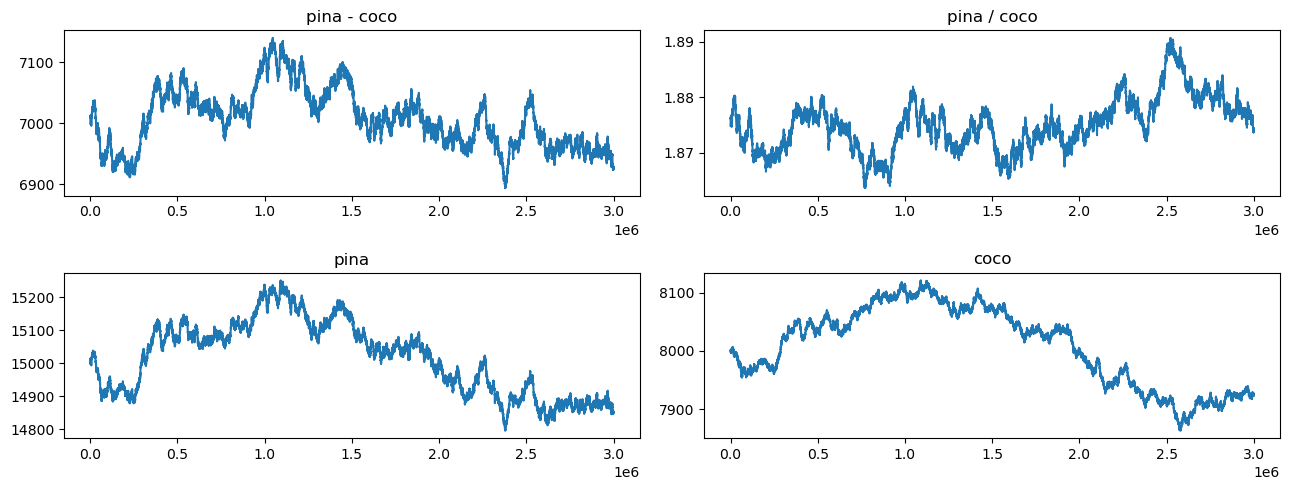

In [206]:
plt.figure(figsize=(13, 5))

plt.subplot(221)
plt.plot(pair_quote_df["time"], pair_quote_df["mid_diff"], label="pina - coco")
plt.title("pina - coco")

plt.subplot(222)
plt.plot(pair_quote_df["time"], pair_quote_df["mid_ratio"], label="pina / coco")
plt.title("pina / coco")

plt.subplot(223)
plt.plot(pina_quote_df["time"], pina_quote_df["mid_price"], label="pina")
plt.title("pina")

plt.subplot(224)
plt.plot(coco_quote_df["time"], coco_quote_df["mid_price"], label="coco")
plt.title("coco")

plt.tight_layout()
plt.show()


## pina: d_-1 vs d_1

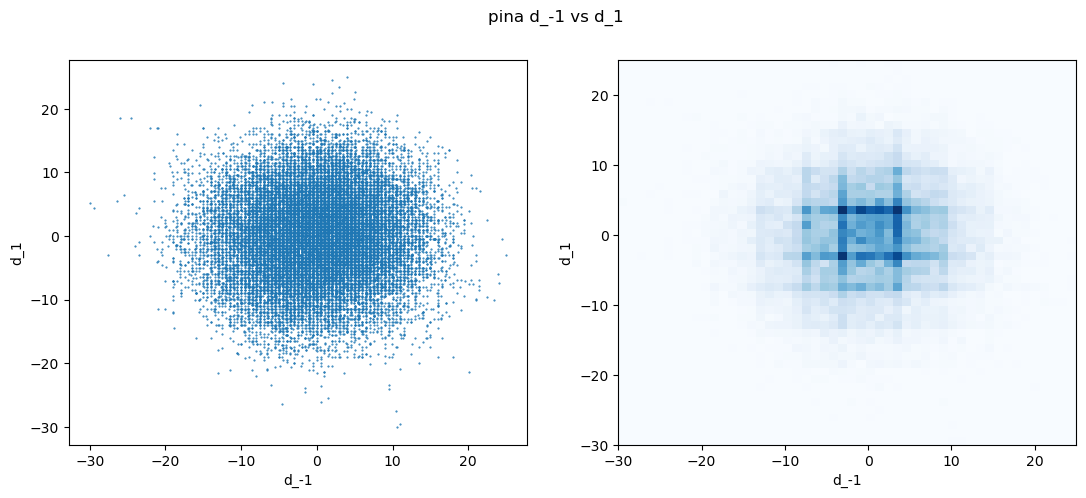

In [207]:
# histogram of d_-1 vs d_1
x = pina_rtn_df["d_-10"]
y = pina_rtn_df["d_10"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.suptitle("pina d_-1 vs d_1")
plt.show()


## coco: d_-1 vs d_1

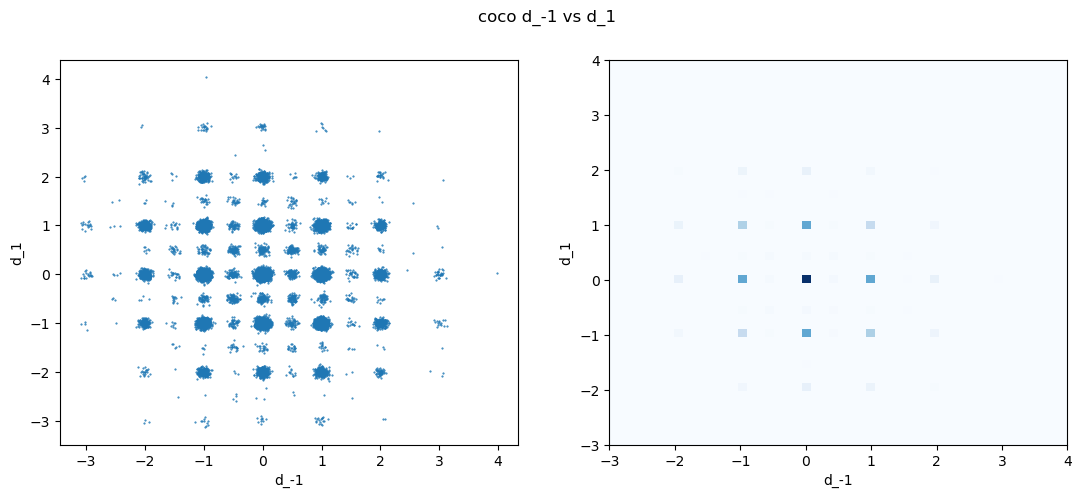

In [208]:
# histogram of d_-1 vs d_1
x = coco_rtn_df["d_-1"]
y = coco_rtn_df["d_1"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("d_-1")
plt.ylabel("d_1")

plt.suptitle("coco d_-1 vs d_1")
plt.show()


## pair: pina d_1 vs coco d_1

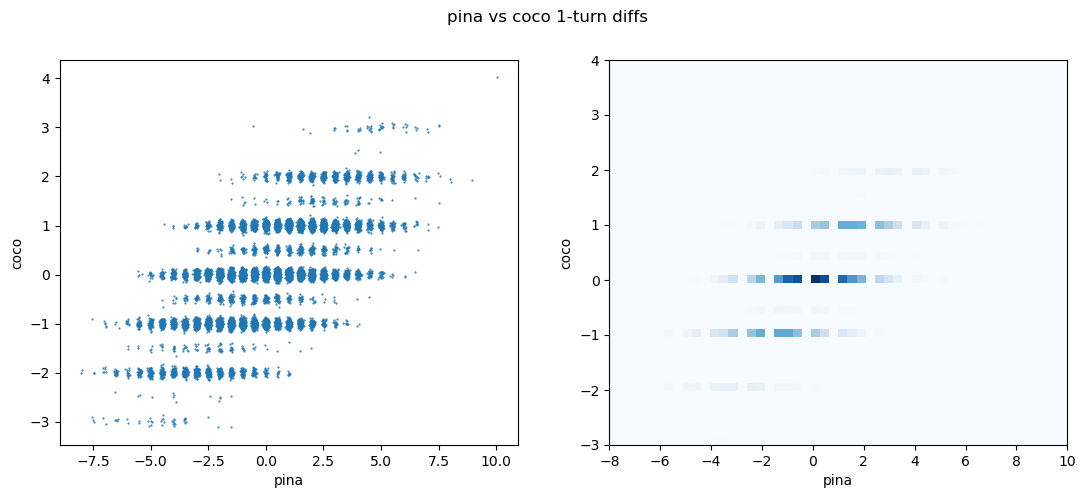

In [209]:
## plot pairs data

x = pina_rtn_df["d_1"]
y = coco_rtn_df["d_1"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("pina")
plt.ylabel("coco")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("pina")
plt.ylabel("coco")

plt.suptitle("pina vs coco 1-turn diffs")
plt.show()


## pair: predict pina -> coco

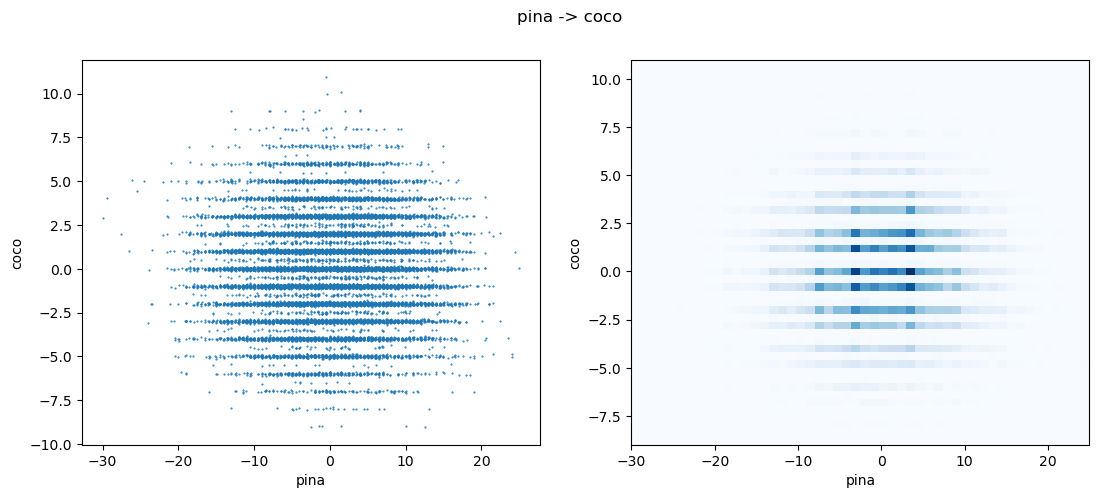

In [210]:
## plot pairs data

x = pina_rtn_df["d_-10"]
y = coco_rtn_df["d_10"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("pina")
plt.ylabel("coco")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("pina")
plt.ylabel("coco")

plt.suptitle("pina -> coco")
plt.show()


## pair: predict pina -> coco

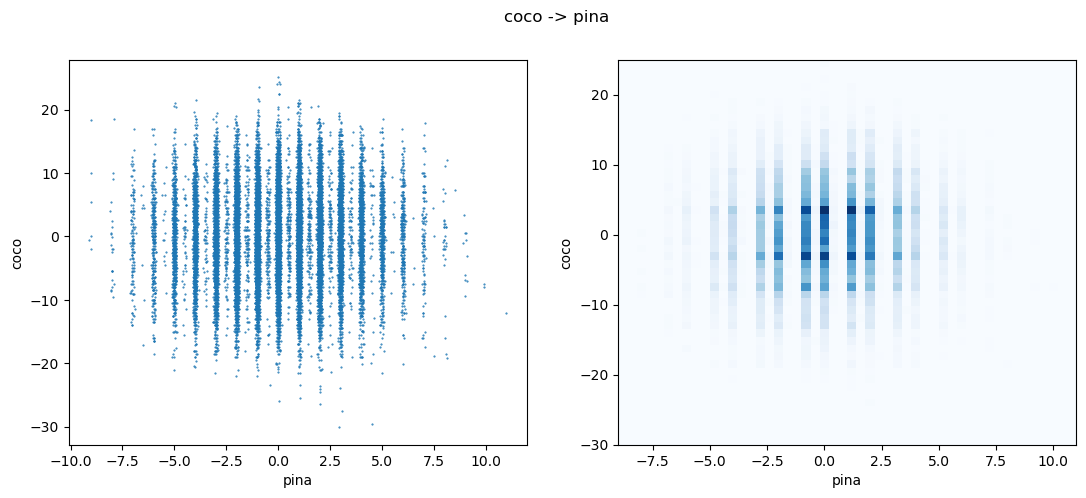

In [211]:
## plot pairs data

x = coco_rtn_df["d_-10"]
y = pina_rtn_df["d_10"]

plt.figure(figsize=(13, 5))

plt.subplot(121)
scatter_noise(x, y, xnoise=0.05, ynoise=0.05, s=0.25)
plt.xlabel("pina")
plt.ylabel("coco")

plt.subplot(122)
plt.hist2d(x, y, bins=50, cmap="Blues")
plt.xlabel("pina")
plt.ylabel("coco")

plt.suptitle("coco -> pina")
plt.show()


## pair trading: return to mean

In [212]:
# fit initial predictor
# X is predicting y

# X = coco_rtn_df[["d_100"]]
# y = pina_rtn_df[["d_100"]]

X = pina_rtn_df[["d_100"]]
y = coco_rtn_df[["d_100"]]

reg = LinearRegression().fit(X, y)

r2 = reg.score(X, y)
print("r2", r2)

print("weight", reg.coef_)
print("bias", reg.intercept_)


r2 0.5586949075883125
weight [[0.28531229]]
bias [-0.09164878]


In [213]:
# use previous error of predictor, to predict future error of predictor
### e.g.

ypred = reg.predict(X)

pred_df = pd.DataFrame(ypred, columns=y.columns.str.replace("d", "pred"), index=y.index)

for col in y.columns:
    offset = col.replace("d_", "")
    
    orig_col = "d_" + offset
    pred_col = "pred_" + offset
    error_col = "error_" + offset
    prev_error_col = "prev_error_" + offset
    
    # create pred_df with 
    pred_df[orig_col] = y[orig_col]
    pred_df[error_col] = pred_df[orig_col] - pred_df[pred_col]

    # get previous turns error
    pred_df[prev_error_col] = pred_df[error_col].shift(-1 * -100)
    
pred_df = pred_df.dropna()

# add time col
pred_df["time"] = pina_quote_df["time"]


In [270]:
def show_preds(
        chunk_size,
        chunk_index_start=0,
        num_shown=2,
        ):
    
    xcol = "prev_error_100"
    ycol = "error_100"
    
#     num_chunks = np.ceil(len(pred_df) / chunk_size).astype(int)

    for i in range(num_shown):
        
        chunk_index = chunk_index_start + i
        
        lb = chunk_size * chunk_index
        ub = min(lb + chunk_size, len(pred_df))
        df = pred_df.iloc[lb:ub]
        
        
        # calculate the time lb/ubs
        time_lb = df.iloc[0]["time"]
        time_ub = df.iloc[-1]["time"]
        
        print(lb, ub, time_lb, time_ub)

        scatter_noise(df[xcol], df[ycol], s=1, label=f"{time_lb} - {time_ub}")
        
    xmin = pred_df[xcol].min()
    xmax = pred_df[xcol].max()
    ymin = pred_df[ycol].min()
    ymax = pred_df[ycol].max()
        
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    
    plt.title(f"prev_error vs error - chunk_size={chunk_size}")
    
    plt.show()
    


In [271]:
interact(
    show_preds,
    chunk_size=200,
    chunk_index_start=(0, 1000, 1),
    num_shown=(1, 100, 1),
)

interactive(children=(IntSlider(value=200, description='chunk_size', max=600, min=-200), IntSlider(value=0, de…

<function __main__.show_preds(chunk_size, chunk_index_start=0, num_shown=2)>

In [216]:
X, y = pred_df[["prev_error_100"]], pred_df["error_100"]

reg = LinearRegression().fit(X, y)

print("r2", reg.score(X, y))


r2 0.0009164296545475237


## relative value

,count,mean,std,min,25%,50%,75%,max
mid_ratio,30000.0,1.875039,0.004713,1.863673,1.871612,1.875039,1.877718,1.890663


Text(0.5, 1.0, 'mid ratio hist')

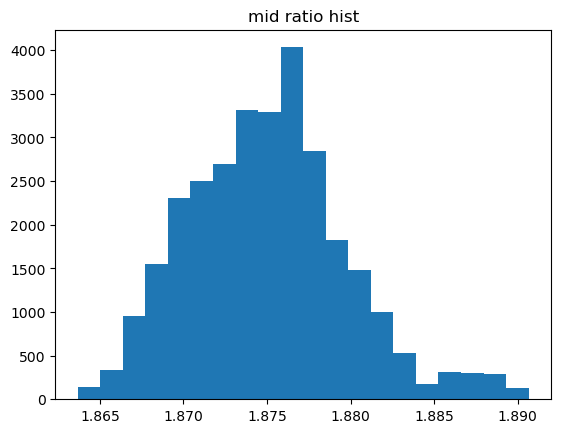

In [217]:
# show stats on mid ratio
display(pair_quote_df[["mid_ratio"]].describe().T)

plt.hist(pair_quote_df["mid_ratio"], bins=20)
plt.title("mid ratio hist")

In [272]:
pair_quote_df["ratio_ma"] = pair_quote_df["mid_ratio"].ewm(span=21).mean()
pair_quote_df["ratio_diff"] = pair_quote_df["mid_ratio"] - pair_quote_df["ratio_ma"]
pair_quote_df

,time,mid_diff,mid_ratio,ratio_ma,ratio_diff
0,0,6999.5,1.874883,1.874883,0.000000
1,100,7000.5,1.875117,1.875006,0.000112
2,200,7001.0,1.875289,1.875109,0.000180
3,300,7000.5,1.875117,1.875112,0.000006
4,400,7000.5,1.875227,1.875139,0.000087
...,...,...,...,...,...
29995,2999500,6926.5,1.874061,1.874026,0.000035
29996,2999600,6929.0,1.874322,1.874053,0.000268
29997,2999700,6927.0,1.874235,1.874070,0.000165
29998,2999800,6926.0,1.873998,1.874063,-0.000065


In [350]:
pair_quote_df["mid_ratio"].mean()


1.8750388288561821

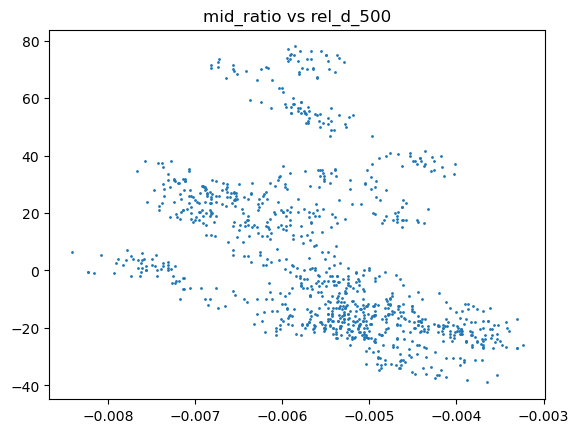

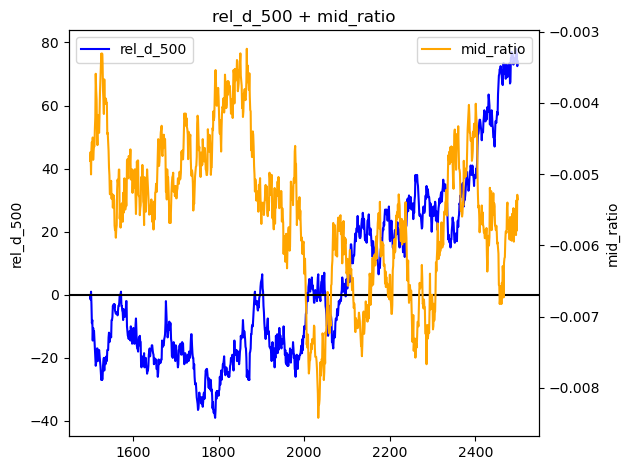

In [281]:
offset = 500
lb, lb_offset = 1000, 1000
ub = lb + lb_offset

inds = pair_rtn_df.index.intersection(pair_quote_df.index)
inds = inds.to_series().iloc[lb:ub]

# mid ratio vs rel_d_offset
rvs = pair_quote_df.loc[inds]["mid_ratio"] - pair_quote_df["mid_ratio"].mean()
# rvs = pair_quote_df.loc[inds]["ratio_diff"]
rtns = pair_rtn_df.loc[inds][f"rel_d_{offset}"]

plt.scatter(
    x=rvs,
    y=rtns,
    s=1,
)
plt.title(f"mid_ratio vs rel_d_{offset}")
plt.show()

## first axis

fig, ax1 = plt.subplots()

ax1.plot(
    inds,
    rtns,
    label=f"rel_d_{offset}",
    color="blue",
)
ax1.set_ylabel(f"rel_d_{offset}")

## second axis

ax2 = ax1.twinx()
ax2.plot(
    inds,
    rvs,
    label="mid_ratio",
    color="orange",
)
ax2.set_ylabel("mid_ratio")

# draw hlines
ax1.axhline(y=0, color="black")

# draw labels
ax1.legend(loc=2)
ax2.legend(loc=1)

# overall plot features
plt.title(f"rel_d_{offset} + mid_ratio")

plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(coco_quote_df["mid_price"], pina_quote_df["mid_price"], s=0.1)

In [349]:
trade_stats = trade_df.groupby("edge")[["quantity"]].sum()

plt.bar(trade_stats.index, trade_stats["quantity"])

KeyError: 'edge'

In [297]:
trade_df

,time,symbol,price,quantity,day,mid_price,edge
0,7200,PINA_COLADAS,15015.0,4,-1,15013.5,-1.5
1,8100,PINA_COLADAS,15011.0,6,-1,15012.0,1.0
2,10300,PINA_COLADAS,15027.0,4,-1,15029.0,2.0
3,14700,PINA_COLADAS,15025.0,8,-1,15026.0,1.0
4,16700,PINA_COLADAS,15036.0,30,-1,15037.0,1.0
...,...,...,...,...,...,...,...
849,2996700,PINA_COLADAS,14854.0,22,1,14855.0,1.0
850,2996700,PINA_COLADAS,14854.0,9,1,14855.0,1.0
851,2997000,PINA_COLADAS,14853.0,10,1,14854.5,1.5
852,2997200,PINA_COLADAS,14848.0,2,1,14849.5,1.5
